# Training the ML Model

## Import General Dependencies

In [2]:
# Data Manipulation Dependencies
import numpy as np
import pandas as pd
from datetime import date

# Graphing Dependencies
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Dependencies
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score

## Import Data

In [3]:
df = pd.read_csv('./data/flat-prices.csv', sep=',', header=0)
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287196 entries, 0 to 287195
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                287196 non-null  object 
 1   town                 287196 non-null  object 
 2   flat_type            287196 non-null  object 
 3   block                287196 non-null  object 
 4   street_name          287196 non-null  object 
 5   storey_range         287196 non-null  object 
 6   floor_area_sqm       287196 non-null  float64
 7   flat_model           287196 non-null  object 
 8   lease_commence_date  287196 non-null  int64  
 9   resale_price         287196 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 21.9+ MB


In [5]:
df.describe()

,floor_area_sqm,lease_commence_date,resale_price
count,287196.000000,287196.000000,287196.00000
mean,93.351778,1983.206897,219541.67471
std,27.361872,6.085632,128145.25346
min,28.000000,1967.000000,5000.00000
25%,68.000000,1979.000000,127000.00000
50%,91.000000,1984.000000,195000.00000
75%,113.000000,1987.000000,298000.00000
max,307.000000,1997.000000,900000.00000


## Data Pre-Processing

In [6]:
# Convert approval_date to datetime type
df['approval_date'] = pd.DatetimeIndex(df['month'])

# Convert approval_date to integer type
# df['approval_date'] = df['approval_date'].apply(lambda x: date.toordinal(x))

In [7]:
# Rename lease_commence_date to more appropriate "lease_commencement_year"
df['lease_commencement_year'] = df['lease_commence_date']

In [8]:
# Estimate storey using storey_range
df['storey'] = df['storey_range'].apply(lambda x: int(np.array(x.split(' TO '), dtype=int).mean()))

In [9]:
# Extract number of bedrooms from flat_type
df['bedrooms'] = df['flat_type'].apply(lambda x: {
    '1 ROOM': 1,
    '2 ROOM': 1,
    '3 ROOM': 2,
    '4 ROOM': 3,
    '5 ROOM': 3,
    'EXECUTIVE': 3,
    'MULTI GENERATION': 4
}[x])

In [10]:
# Convert resale_price (target) to float type
df['resale_price'] = df['resale_price'].astype(float)

In [11]:
# Drop unused columns
df.drop(columns=[
    'month',
    'town',
    'flat_type',
    'block',
    'street_name',
    'storey_range',
    'flat_model',
    'lease_commence_date',
    'storey'
], inplace=True)


## Exploratory Data Analysis

<AxesSubplot:xlabel='floor_area_sqm', ylabel='resale_price'>

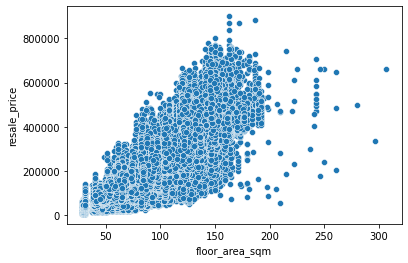

In [12]:
sns.scatterplot(data=df, x='floor_area_sqm', y='resale_price')

In [13]:
df = df[df['floor_area_sqm'] < 200]

## Partition Data

In [14]:
X = df.drop(columns='resale_price')
y = df['resale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25)

## Build ML Pipeline

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class DateConverter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['approval_date'] = X_copy['approval_date'].apply(date.toordinal)
        return X_copy

In [40]:
# pipeline = Pipeline(steps=[
#     ('date_conv', DateConverter()),
#     ('scaler', StandardScaler()),
#     ('model', LinearRegression(fit_intercept=True))
# ])

In [17]:
import cloudpickle
with open('./model/regressor.p', 'rb') as f:
    pipeline = cloudpickle.load(f)

In [18]:
cross_val_score(estimator=pipeline, X=X_train, y=y_train, cv=5)

array([0.78575068, 0.78629367, 0.78675168, 0.78892406, 0.78492242])

## Model Evaluation

In [41]:
# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('date_conv', DateConverter()), ('scaler', StandardScaler()),
                ('model', LinearRegression())])

In [20]:
y_train_pred = pipeline.predict(X_train)
mean_absolute_percentage_error(y_train, y_train_pred), \
mean_absolute_error(y_train, y_train_pred), \
r2_score(y_train, y_train_pred)

(0.26771934890925275, 44386.61450573441, 0.7865421787615279)

In [21]:
y_pred = pipeline.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred), \
mean_absolute_error(y_test, y_pred), \
r2_score(y_test, y_pred)

(0.26893237728374464, 44502.461400233624, 0.7862316175515123)

In [42]:
pipeline.named_steps['model'].coef_

array([99452.82494122, 50968.15068354, -4958.89366124, -1989.67395523])

In [23]:
def create_stencil(variable: str, **kwargs):
    length = len(kwargs[variable])
    for i in kwargs:
        if i != variable:
            kwargs[i] = np.resize(np.array([kwargs[i]]), (length,))
    return pd.DataFrame(kwargs)[['floor_area_sqm', 'approval_date', 'lease_commencement_year', 'bedrooms']]

In [24]:
create_stencil(variable='approval_date', floor_area_sqm=100.0, approval_date=[date(1997, 12, 3), date(2000, 6, 7)], lease_commencement_year=2000, bedrooms=3)

,floor_area_sqm,approval_date,lease_commencement_year,bedrooms
0,100.0,1997-12-03,2000,3
1,100.0,2000-06-07,2000,3


In [52]:
# input_boundaries = pd.DataFrame(data={
#     'approval_date': [X['approval_date'].min(), X['approval_date'].max()],
#     'bedrooms': [X['bedrooms'].min(), X['bedrooms'].max()],
#     'lease_commencement_year': [X['lease_commencement_year'].min(), X['lease_commencement_year'].max()],
#     'floor_area_sqm': [X['floor_area_sqm'].min(), X['floor_area_sqm'].max()]
# }, index=['min', 'max'])
with open('./model/input_boundaries.p', 'rb') as bounds_file:
    input_boundaries = cloudpickle.load(file=bounds_file)
input_boundaries

,approval_date,bedrooms,lease_commencement_year,floor_area_sqm
min,1990-01-01,1,1967,28.0
max,1999-12-01,4,1997,199.0


In [55]:
# output_boundaries = dict(min=y.min(), max=y.max())
with open('./model/output_boundaries.p', 'rb') as output_bounds_file:
    output_boundaries = cloudpickle.load(file=output_bounds_file)
output_boundaries

{'min': 5000.0, 'max': 900000.0}

In [32]:
def get_regression_plot(variable, mark, ax, **kwargs):
    import cloudpickle
    with open('./model/input_boundaries.p', 'rb') as bounds_file:
        lookup = cloudpickle.load(file=bounds_file)
    x_var = lookup[variable]

    x = (x_var['min'], x_var['max'])
    del kwargs[variable]
    y = pipeline.predict(create_stencil(variable, **{variable: x}, **kwargs))
    resale_price = pipeline.predict(create_stencil(variable, **{variable: (mark,)}, **kwargs))
    sns.lineplot(x=x, y=y, ax=ax)
    sns.scatterplot(x=mark, y=resale_price, ax=ax)
    ax.set_title(variable)
    ax.set_ylabel('Predicted Resale Price')
    ax.set_xticks(x)
    ax.set_yticklabels([f'{i / 1000:.0f}k' for i in ax.get_yticks()])

In [44]:
def get_regression_plots(bedrooms, floor_area_sqm, approval_date, lease_commencement_year):
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    get_regression_plot(variable='bedrooms', mark=bedrooms, bedrooms=bedrooms, floor_area_sqm=floor_area_sqm,
                        approval_date=approval_date, lease_commencement_year=lease_commencement_year, ax=ax[0, 0])
    get_regression_plot(variable='floor_area_sqm', mark=floor_area_sqm, bedrooms=bedrooms, floor_area_sqm=floor_area_sqm,
                        approval_date=approval_date, lease_commencement_year=lease_commencement_year, ax=ax[0, 1])
    get_regression_plot(variable='approval_date', mark=approval_date, bedrooms=bedrooms, floor_area_sqm=floor_area_sqm,
                        approval_date=approval_date, lease_commencement_year=lease_commencement_year, ax=ax[1, 0])
    get_regression_plot(variable='lease_commencement_year', mark=lease_commencement_year, bedrooms=bedrooms, floor_area_sqm=floor_area_sqm,
                        approval_date=approval_date, lease_commencement_year=lease_commencement_year, ax=ax[1, 1])
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

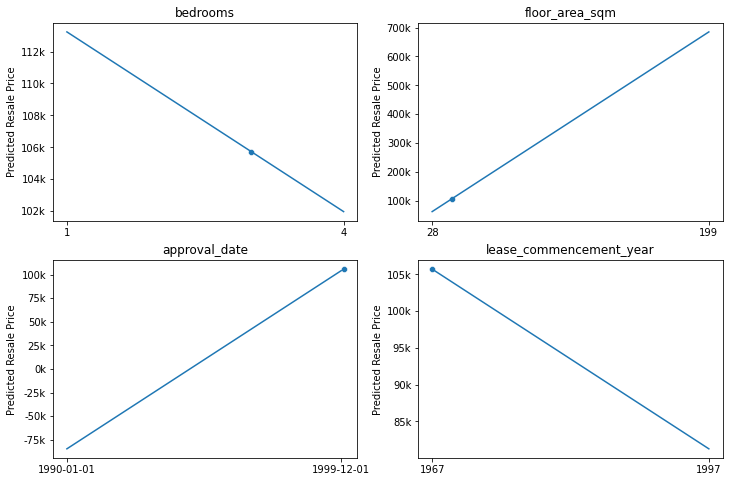

In [51]:
import warnings
warnings.filterwarnings('ignore')

get_regression_plots(3, 40.0, date(2000, 1, 1), 1967)

## Model Export

In [54]:
# import cloudpickle

# with open('./model/regressor.p', 'wb') as model_file:
#     cloudpickle.dump(file=model_file, obj=pipeline)

# with open('./model/input_boundaries.p', 'wb') as bounds_file:
#     cloudpickle.dump(file=bounds_file, obj=input_boundaries)

# with open('./model/output_boundaries.p', 'wb') as output_bounds_file:
#     cloudpickle.dump(file=output_bounds_file, obj=output_boundaries)